In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from sklearn.model_selection import cross_val_score, KFold
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler


In [165]:
# 1. Đọc dữ liệu từ file CSV
df = pd.read_csv('Gold_Price.csv')

In [166]:
print(df.dtypes)


Date       object
Price       int64
Open        int64
High        int64
Low         int64
Volume      int64
Chg%      float64
dtype: object


In [167]:


# # Bước 1: Chuyển đổi cột 'Date' thành datetime
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# # Bước 2: Loại bỏ dấu phẩy và chuyển đổi các cột về kiểu float
# for col in ['Price', 'Open', 'High', 'Low']:
#     df[col] = df[col].replace({',': ''}, regex=True).astype(float)

# # Bước 3: Xử lý cột 'Vol.' để chuyển đổi giá trị có ký hiệu 'K' thành số thực
# df['Vol.'] = df['Vol.'].replace({',': ''}, regex=True)
# df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('K', '')) * 1000 if 'K' in str(x) else float(x))

# # Bước 4: Loại bỏ dấu phần trăm trong cột 'Change %' và chuyển đổi về kiểu float
# df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# # Kiểm tra lại kết quả
# print(df.dtypes)
# print(df.head())


In [168]:
# # Xóa dấu phân cách hàng nghìn và chuyển đổi sang kiểu float trước khi đổi sang int64
# for col in df.select_dtypes(include=['object']).columns:
#     # Loại bỏ dấu phẩy nếu có trong dữ liệu và chuyển sang float
#     df[col] = df[col].str.replace(',','').astype(float)

# # Sau khi tất cả các cột đã được chuyển về dạng float, chuyển sang int64 nếu cần
# for col in df.columns:
#     if df[col].dtype == 'float64':
#         df[col] = df[col].astype('int64')

# # Kiểm tra lại kiểu dữ liệu và hiển thị dữ liệu đầu ra
# print(df.dtypes)
# print(df.head())


In [169]:
# # Đầu tiên chuyển các cột dữ liệu về dạng số nếu có giá trị chuỗi
# df = df.apply(pd.to_numeric, errors='coerce')

# # Đổi các cột dạng float64 thành int64
# for col in df.select_dtypes(include=['float64', 'int32']).columns:
#     df[col] = df[col].fillna(0).astype('int64')  # Điền giá trị thiếu (nếu có) và đổi kiểu

# # Kiểm tra lại kiểu dữ liệu
# print(df.dtypes)


In [170]:
# Hiển thị thông tin tổng quan về dữ liệu
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2227 non-null   object 
 1   Price   2227 non-null   int64  
 2   Open    2227 non-null   int64  
 3   High    2227 non-null   int64  
 4   Low     2227 non-null   int64  
 5   Volume  2227 non-null   int64  
 6   Chg%    2227 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 121.9+ KB
None


In [171]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%'], dtype='object')

In [172]:
def compare_predictions(y_test, y_pred, model_name):
    comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(f"\nComparison for {model_name} model:")
    print(comparison.head())  # Hiển thị 5 giá trị đầu tiên

In [173]:
df.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,1/1/2014,29542,29435,29598,29340,2930,0.25
1,1/2/2014,29975,29678,30050,29678,3140,1.47
2,1/3/2014,29727,30031,30125,29539,3050,-0.83
3,1/4/2014,29279,29279,29279,29279,0,-1.51
4,1/6/2014,29119,29300,29395,29051,24380,-0.55


# TIỀN XỬ LÍ DỮ LIỆU

In [174]:
# #Vì chúng tôi sẽ không sử dụng Vol. và Thay đổi tính năng % để dự đoán Giá, chúng tôi sẽ bỏ hai tính năng này
# df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [175]:

# Chuyển đổi cột "date" sang kiểu datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  

# Tách các đặc trưng số từ cột "date"
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_year'] = df['Date'].dt.dayofyear

# Xóa cột "date" gốc vì không cần thiết cho mô hình
df = df.drop(columns=['Date'])

# Đảm bảo không có giá trị null (do lỗi chuyển đổi date) và mọi cột đều là số
df = df.dropna()




In [176]:
# Xử lý dữ liệu cho mô hình
X = df.drop(columns=['Price'])  # 'target_column' là cột đích bạn muốn dự đoán
y = df['Price']

In [177]:
X.head()


,Open,High,Low,Volume,Chg%,year,month,day,day_of_week,day_of_year
0,29435,29598,29340,2930,0.25,2014,1,1,2,1
1,29678,30050,29678,3140,1.47,2014,1,2,3,2
2,30031,30125,29539,3050,-0.83,2014,1,3,4,3
3,29279,29279,29279,0,-1.51,2014,1,4,5,4
4,29300,29395,29051,24380,-0.55,2014,1,6,0,6


In [178]:
y.head()

0    29542
1    29975
2    29727
3    29279
4    29119
Name: Price, dtype: int64

In [179]:
# # Giả sử bạn có một cột chứa các giá trị dạng chuỗi
# df['Price'] = df['Price'].str.replace(',', '')  # Loại bỏ dấu phẩy
# df['Price'] = df['Price'].astype(float)  # Chuyển đổi thành float



In [180]:
# # Giả sử bạn có một cột chứa các giá trị dạng chuỗi
# df['High'] = df['High'].str.replace(',', '')  # Loại bỏ dấu phẩy
# df['High'] = df['High'].astype(float)  # Chuyển đổi thành float

In [181]:
X.head()


,Open,High,Low,Volume,Chg%,year,month,day,day_of_week,day_of_year
0,29435,29598,29340,2930,0.25,2014,1,1,2,1
1,29678,30050,29678,3140,1.47,2014,1,2,3,2
2,30031,30125,29539,3050,-0.83,2014,1,3,4,3
3,29279,29279,29279,0,-1.51,2014,1,4,5,4
4,29300,29395,29051,24380,-0.55,2014,1,6,0,6


In [182]:
# # Giả sử bạn có một cột chứa các giá trị dạng chuỗi
# df['Low'] = df['Low'].str.replace(',', '')  # Loại bỏ dấu phẩy
# df['Low'] = df['Low'].astype(float)  # Chuyển đổi thành float

In [183]:
# Lấy kích thước của DataFrame cho năm 2022
test_size = df[df['year'] == 2022].shape[0]
print(test_size)


153


In [184]:
window_size = 60


In [185]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [186]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [1]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

NameError: name 'window_size' is not defined

In [188]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [189]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [190]:
# # 3. Chia dữ liệu thành tập huấn luyện và kiểm thử (70% huấn luyện, 30% kiểm thử)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
# # Chuyển đổi y_train
# y_train = y_train.str.replace(',', '').astype(float)


In [192]:
# # Kiểm tra các giá trị trong cột Open để xác định lỗi
# print(df['Open'].head(10))  # Kiểm tra thử 10 dòng đầu tiên để xem cấu trúc dữ liệu

# # Xóa dấu phẩy và chuyển đổi sang float
# df['Open'] = df['Open'].replace(',', '', regex=True)  # Xóa dấu phẩy trong chuỗi

# # Kiểm tra lại kiểu dữ liệu sau khi chuyển đổi
# df['Open'] = pd.to_numeric(df['Open'], errors='coerce')  # Chuyển đổi dữ liệu về dạng số
# print(df.dtypes)  # Xác nhận kiểu dữ liệu



In [193]:
print(df.dtypes)


Price            int64
Open             int64
High             int64
Low              int64
Volume           int64
Chg%           float64
year             int32
month            int32
day              int32
day_of_week      int32
day_of_year      int32
dtype: object


# HỒI QUY TUYẾN TÍNH

In [194]:
# 4. Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
compare_predictions(y_test, y_pred_lr, "Linear Regression")


Comparison for Linear Regression model:
     Actual  Predicted
0  0.726213   0.745176
1  0.735398   0.724465
2  0.744520   0.730938
3  0.727037   0.744204
4  0.726466   0.728979


In [195]:

# Dự đoán trên tập kiểm tra
y_pred_lr = model_lr.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)

rmse_linear = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_linear = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_linear}, RMSE: {rmse_linear}, R2: {r2_linear}")

Linear Regression - MAE: 0.010321747719532018, RMSE: 0.013953292272500693, R2: 0.9060959738648107


In [196]:
# plt.scatter(y_test, y_pred_lr, label="Linear Regression")
# plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
# plt.xlabel("Giá thực tế")
# plt.ylabel("Giá dự đoán")
# plt.legend()
# plt.title("Biểu đồ giữa dự đoán và thực tế của mô hình")
# plt.show()


# Rigde


In [197]:

# Khởi tạo và huấn luyện Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred_ridge = ridge_reg.predict(X_test)

# Đánh giá mô hình Ridge Regression
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = math.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression - MAE: {mae_ridge}, RMSE: {rmse_ridge}, R2: {r2_ridge}")


Ridge Regression - MAE: 0.011338988132144276, RMSE: 0.015622449555943255, R2: 0.8822857357332812


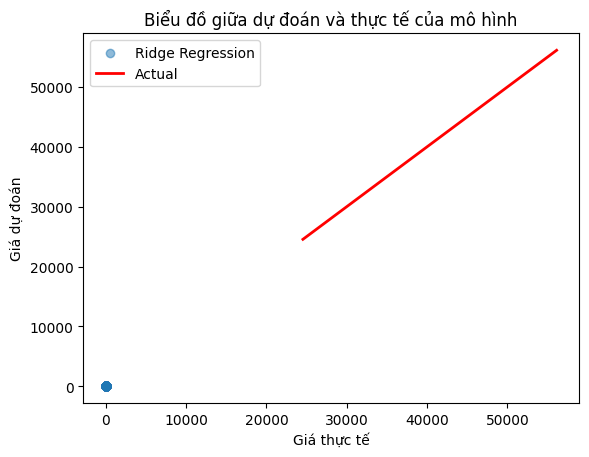

In [198]:
plt.scatter(y_test, y_pred_ridge, label="Ridge Regression", alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.legend()
plt.title("Biểu đồ giữa dự đoán và thực tế của mô hình")
plt.show()

# Neural network

In [201]:
# 6. Neural Network (MLPRegressor)
model_nn = MLPRegressor(hidden_layer_sizes=(100, 50),activation='relu', max_iter=500)
model_nn.fit(X_train, y_train)
y_pred_nn = model_nn.predict(X_test)
compare_predictions(y_test, y_pred_nn, "Neural Network")


Comparison for Neural Network model:
     Actual  Predicted
0  0.726213   0.760726
1  0.735398   0.754695
2  0.744520   0.740656
3  0.727037   0.737857
4  0.726466   0.743325


In [152]:
# Đánh giá mô hình Neural Network
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = math.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MAE: {mae_nn}, RMSE: {rmse_nn}, R2: {r2_nn}")

Neural Network - MAE: 0.02253019600396863, RMSE: 0.028150478861397193, R2: 0.6177896842466044


In [153]:
# Đánh giá mô hình Neural Network
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = math.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MAE: {mae_nn}, RMSE: {rmse_nn}, R2: {r2_nn}")

Neural Network - MAE: 0.02253019600396863, RMSE: 0.028150478861397193, R2: 0.6177896842466044


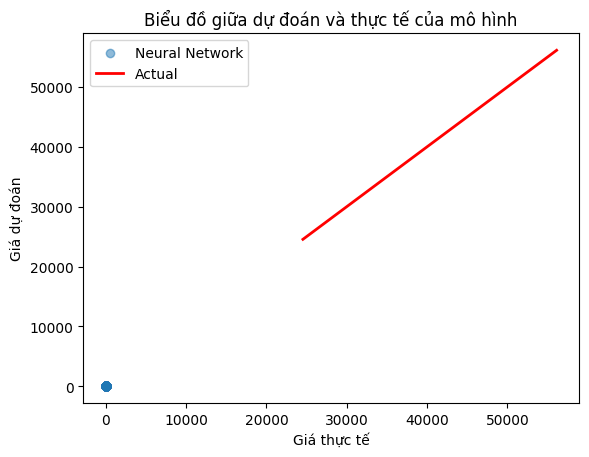

In [154]:
plt.scatter(y_test, y_pred_nn, label="Neural Network", alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.legend()
plt.title("Biểu đồ giữa dự đoán và thực tế của mô hình")
plt.show()

In [155]:
# Sử dụng 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Fold cho Linear Regression
cv_r2_scores_linear = cross_val_score(model_lr, X_train, y_train, cv=kf, scoring='r2')
print(f"Linear Regression R^2 scores (K-Fold): {cv_r2_scores_linear}")
print(f"Mean R^2 on training set for Linear Regression: {np.mean(cv_r2_scores_linear)}")

# K-Fold cho Ridge Regression
cv_r2_scores_ridge = cross_val_score(ridge_reg, X_train, y_train, cv=kf, scoring='r2')
print(f"Ridge Regression R^2 scores (K-Fold): {cv_r2_scores_ridge}")
print(f"Mean R^2 on training set for Ridge Regression: {np.mean(cv_r2_scores_ridge)}")

# K-Fold cho Neural Network (MLPRegressor)
cv_r2_scores_nn = cross_val_score(model_nn, X_train, y_train, cv=kf, scoring='r2')
print(f"Neural Network R^2 scores (K-Fold): {cv_r2_scores_nn}")
print(f"Mean R^2 on training set for Neural Network: {np.mean(cv_r2_scores_nn)}")

# So sánh kết quả R² trên tập kiểm tra và tập huấn luyện
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
r2_test_ridge = r2_score(y_test, y_pred_ridge)
print(f"R^2 on test set for Ridge Regression: {r2_test_ridge}")

model_lr.fit(X_train, y_train)
y_pred_linear = model_lr.predict(X_test)
r2_test_linear = r2_score(y_test, y_pred_linear)
print(f"R^2 on test set for Linear Regression: {r2_test_linear}")

model_nn.fit(X_train, y_train)
y_pred_nn = model_nn.predict(X_test)
r2_test_nn = r2_score(y_test, y_pred_nn)
print(f"R^2 on test set for Neural Network: {r2_test_nn}")

# Kiểm tra overfitting
if r2_test_ridge < np.mean(cv_r2_scores_ridge) - 0.1:
    print("Ridge model: Possible overfitting detected")
else:
    print("Ridge model: No overfitting detected")

if r2_test_linear < np.mean(cv_r2_scores_linear) - 0.1:
    print("Linear model: Possible overfitting detected")
else:
    print("Linear model: No overfitting detected")

if r2_test_nn < np.mean(cv_r2_scores_nn) - 0.1:
    print("Neural Network model: Possible overfitting detected")
else:
    print("Neural Network model: No overfitting detected")

Linear Regression R^2 scores (K-Fold): [0.99888116 0.99829624 0.99870465 0.99828385 0.99855611]
Mean R^2 on training set for Linear Regression: 0.9985443988018268
Ridge Regression R^2 scores (K-Fold): [0.99789473 0.99695437 0.99705426 0.99714385 0.99777352]
Mean R^2 on training set for Ridge Regression: 0.9973641462601359
Neural Network R^2 scores (K-Fold): [0.99202089 0.99119503 0.98807744 0.99090887 0.98111252]
Mean R^2 on training set for Neural Network: 0.9886629493143371
R^2 on test set for Ridge Regression: 0.8822857357332812
R^2 on test set for Linear Regression: 0.9060959738648107
R^2 on test set for Neural Network: 0.5506867087604426
Ridge model: Possible overfitting detected
Linear model: No overfitting detected
Neural Network model: Possible overfitting detected


In [156]:
# 7. Stacking Model
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge(alpha=1.0)),
    ('nn', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
compare_predictions(y_test, y_pred_stack, "Stacking")


Comparison for Stacking model:
     Actual  Predicted
0  0.726213   0.743848
1  0.735398   0.723440
2  0.744520   0.729890
3  0.727037   0.743016
4  0.726466   0.728051


In [157]:
# Đánh giá mô hình Stacking
mae_stack = mean_absolute_error(y_test, y_pred_stack)
rmse_stack = math.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Model - MAE: {mae_stack}, RMSE: {rmse_stack}, R²: {r2_stack}")


Stacking Model - MAE: 0.010529169225584485, RMSE: 0.014079837061760797, R²: 0.9043849869897261


In [158]:
# K-Fold Cross-Validation cho Stacking Model
cv_r2_scores_stack = cross_val_score(stacking_model, X_train, y_train, cv=kf, scoring='r2')
print(f"Stacking Model R² scores (K-Fold): {cv_r2_scores_stack}")
print(f"Mean R² on training set for Stacking Model: {np.mean(cv_r2_scores_stack)}")


Stacking Model R² scores (K-Fold): [0.99885459 0.99830286 0.99868479 0.99827454 0.99856515]
Mean R² on training set for Stacking Model: 0.9985363869979531


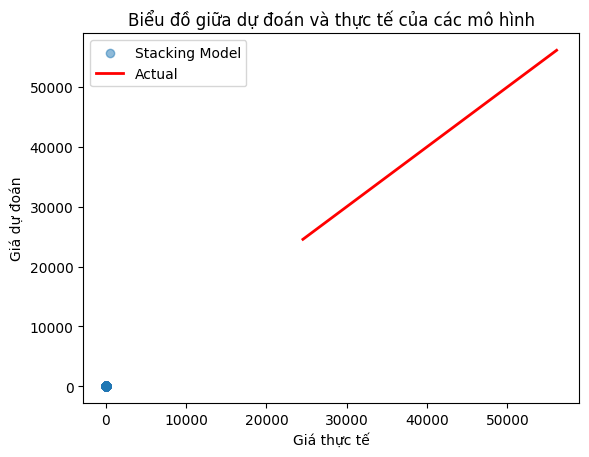

In [159]:
plt.scatter(y_test, y_pred_stack, label="Stacking Model", alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, label="Actual")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.legend()
plt.title("Biểu đồ giữa dự đoán và thực tế của các mô hình")
plt.show()


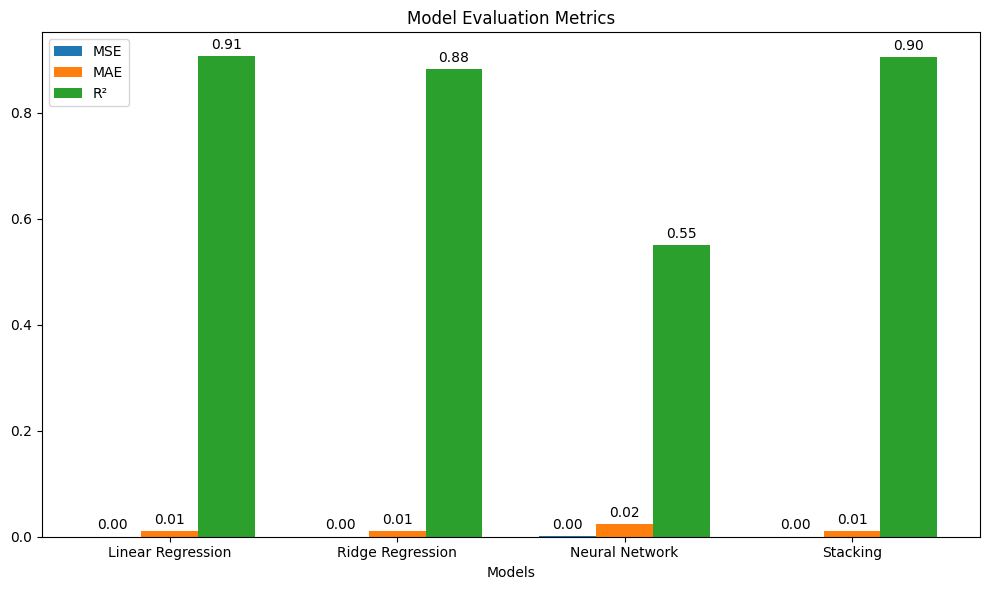

In [161]:
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2

# Danh sách các mô hình và dự đoán
models = ["Linear Regression", "Ridge Regression", "Neural Network", "Stacking"]
predictions = [y_pred_lr, y_pred_ridge, y_pred_nn, y_pred_stack]

# Khởi tạo danh sách để lưu trữ kết quả
mse_list = []
mae_list = []
r2_list = []

# Đánh giá từng mô hình và lưu trữ kết quả
for model_name, y_pred in zip(models, predictions):
    mse, mae, r2 = evaluate_model(y_test, y_pred, model_name)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Vẽ biểu đồ cột cho các độ đo
x = np.arange(len(models))  # Vị trí cho từng mô hình
width = 0.25  # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ cột cho từng độ đo
rects1 = ax.bar(x - width, mse_list, width, label='MSE')
rects2 = ax.bar(x, mae_list, width, label='MAE')
rects3 = ax.bar(x + width, r2_list, width, label='R²')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Models')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Hiển thị giá trị trên cột
def autolabel(rects):
    """Gán nhãn cho mỗi cột."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

In [160]:
# 8. Đánh giá mô hình bằng các chỉ số như MSE, MAE, R²
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Model Evaluation:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    
    

# Đánh giá từng mô hình
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_nn, "Neural Network")
evaluate_model(y_test, y_pred_stack, "Stacking")


Linear Regression Model Evaluation:
MSE: 0.00019469436524182754
MAE: 0.010321747719532018
R²: 0.9060959738648107

Ridge Regression Model Evaluation:
MSE: 0.0002440609301279916
MAE: 0.011338988132144276
R²: 0.8822857357332812

Neural Network Model Evaluation:
MSE: 0.0009315763086309291
MAE: 0.023436513259786754
R²: 0.5506867087604426

Stacking Model Evaluation:
MSE: 0.00019824181168573294
MAE: 0.010529169225584485
R²: 0.9043849869897261
